In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import pynapple as nap

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


In [3]:
mouse = 0
day = 0
session_type = 'OF1'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/COHORT12_nwb/')

alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1
class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

In [4]:
args.session_type = 'OF1'

# Load session
sessions = {}
for session_path in sorted(
    list(args.storage.glob(f'*/*/{args.session_type}/*{args.session_type}_beh.nwb'))
):  
    print(session_path)
    args.mouse = int(session_path.parent.parent.parent.name[1:])
    args.day = int(session_path.parent.parent.name[1:])
    mouse_day = f'M{args.mouse}D{args.day}'
    sessions[mouse_day] = (
        *load_session(args),
        pd.read_parquet(
            session_path.parent / 'tuning_scores' / 'shifted_grid_score.parquet'
        ),
        pd.read_parquet(
            session_path.parent / 'tuning_scores' / 'shifted_spatial_information.parquet'
        ),
    )


/Users/harryclark/Downloads/COHORT12_nwb/M20/D14/OF1/sub-20_day-14_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D15/OF1/sub-20_day-15_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D16/OF1/sub-20_day-16_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D17/OF1/sub-20_day-17_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D18/OF1/sub-20_day-18_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D19/OF1/sub-20_day-19_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D20/OF1/sub-20_day-20_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D21/OF1/sub-20_day-21_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D22/OF1/sub-20_day-22_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D23/OF1/sub-20_day-23_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D24/OF1/sub-20_day-24_ses-OF1_beh.nwb
/Users/harryclark/Downloads/COHORT12_nwb/M20/D25/OF1/sub-20_day-25_ses-OF1_beh.nwb
/Use

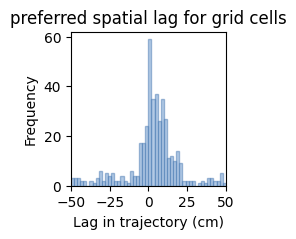

In [5]:
percentile_threshold = 95

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))

travel = np.arange(-50, 50, 2)
travel_at_max = []
travel_at_max_si = []
for mouse_day in sessions.keys():
    predictive_grid_scores = sessions[mouse_day][3]
    spatial_information_scores = sessions[mouse_day][4]

    grids = predictive_grid_scores[(predictive_grid_scores.travel==0) & 
                                   (predictive_grid_scores.sig)]
    spatial = spatial_information_scores[(spatial_information_scores.travel==0) & 
                                         (spatial_information_scores.sig)]
    ids = np.intersect1d(grids.cluster_id, spatial.cluster_id)
    for id in ids:
        id_scores = np.array(predictive_grid_scores[predictive_grid_scores.cluster_id == id].grid_score)
        id_scores_si = np.array(spatial_information_scores[spatial_information_scores.cluster_id == id].spatial_information)
        id_travels = np.array(predictive_grid_scores[predictive_grid_scores.cluster_id == id].travel)
        id_travels_si = np.array(spatial_information_scores[spatial_information_scores.cluster_id == id].travel)

        travel_at_max.append(id_travels[np.nanargmax(id_scores)])
        travel_at_max_si.append(id_travels_si[np.nanargmax(id_scores)])

hist, xedges = np.histogram(travel_at_max, bins=50, range=(-50,50), density=False)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ax.bar(xcenters, hist, alpha=0.5, width=2, color='#6897CD', edgecolor="#4879B2")
ax.set_xlabel('Lag in trajectory (cm)')
ax.set_ylabel('Frequency')
ax.set_xlim(-50,50)
ax.set_xticks([-50, -25, 0, 25, 50])
ax.set_title('preferred spatial lag for grid cells')
fig.savefig(f'/Users/harryclark/Documents/figs/SUPP_Grid_module_classification/classically_defined_grid_cell_maximised_grid_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

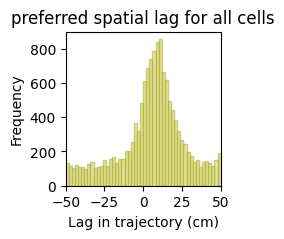

: 

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))

travel = np.arange(-50, 50, 2)
travel_at_max = []
for mouse_day in sessions.keys():
    spatial_information_scores = sessions[mouse_day][4]

    ids = np.unique(spatial_information_scores.cluster_id)

    for id in ids:
        id_scores = np.array(spatial_information_scores[spatial_information_scores.cluster_id == id].spatial_information)
        id_travels = np.array(spatial_information_scores[spatial_information_scores.cluster_id == id].travel)
        travel_at_max.append(id_travels[np.nanargmax(id_scores)])

hist, xedges = np.histogram(travel_at_max, bins=50, range=(-50,50), density=False)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ax.bar(xcenters, hist, alpha=0.5, width=2, color='#CAC841', edgecolor="#A7A41D")
ax.set_xlabel('Lag in trajectory (cm)')
ax.set_ylabel('Frequency')
ax.set_xlim(-50,50)
ax.set_xticks([-50, -25, 0, 25, 50])
ax.set_title('preferred spatial lag for all cells')
plt.show()